# Machine learning model for emissions estimations from concentrations

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

np.random.seed(111)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In this notebook we will apply a Recurrrent Neural Network model to a dataset of concentrations in order to estimate emissions 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


## Datasets

In [ ]:
from create_dataset.make_dataset import CustomDataset

fn = 'Data/3_months_dataset_complete_for_model_NOX.nc'
ds = CustomDataset(fn)

Opening dataset at :  Data/3_months_dataset_complete_for_model_NOX.nc
Done!


Assuming data are already cleaned from NaN and error values

In [ ]:
df = ds.get_dataset().to_dataframe().dropna() # drop nan because 
#df = df.reset_index().drop(columns=['latitude', 'longitude']).set_index('time')
#df = df.reset_index().set_index('time')
df = df.drop(columns = ['traffic'])
df

EMISSIONS  ...  O3_tc_add_trend
latitude longitude time                               ...                 
43.25    4.0       2019-05-01 12:00:00  7.497578e-12  ...         0.007345
                   2019-05-01 13:00:00  7.875607e-12  ...         0.007455
                   2019-05-01 14:00:00  8.379646e-12  ...         0.007430
                   2019-05-01 15:00:00  8.316641e-12  ...         0.007406
                   2019-05-01 16:00:00  8.883684e-12  ...         0.007385
...                                              ...  ...              ...
48.75    10.0      2020-05-29 20:00:00 -4.163053e-13  ...         0.007583
                   2020-05-29 21:00:00 -3.720174e-13  ...         0.007578
                   2020-05-29 22:00:00 -3.233009e-13  ...         0.007572
                   2020-05-29 23:00:00 -1.904375e-13  ...         0.007566
                   2020-05-30 00:00:00 -1.107195e-13  ...         0.007560

[1181625 rows x 31 columns]

In [ ]:
df.describe()

,EMISSIONS,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,rel_hum,tcw,tot_wind,tmp_shift_1,tot_wind_shift_12,rel_hum_shift_8,height,built,NO_tc,CO2_tc,CH4_tc,NO2_tc,CO_tc,O3_tc,NO_tc_add_trend,CO2_tc_add_trend,CH4_tc_add_trend,NO2_tc_add_trend,CO_tc_add_trend,O3_tc_add_trend
count,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06,1.181625e+06
mean,1.073465e-11,1.566229e-01,-7.724150e-01,4.000801e-01,2.137830e-01,5.742391e-01,3.185377e-01,5.601764e-01,9.415342e+04,2.886032e+02,7.753497e-03,1.740671e-04,1.849929e+01,2.307789e+00,2.886076e+02,2.301818e+00,1.750034e-04,5.605611e-01,1.527762e-02,1.095891e-06,4.110054e+02,1.838708e+03,3.422290e-06,8.594525e-04,7.951412e-03,1.096296e-06,4.110073e+02,1.838703e+03,3.418762e-06,8.594058e-04,7.950631e-03
std,3.457842e-11,1.737978e+00,2.058403e+00,3.819878e-01,2.739552e-01,3.544704e-01,1.928609e-01,2.406388e-01,4.927553e+03,6.516604e+00,2.679588e-03,5.109401e-05,6.947784e+00,1.597764e+00,6.519380e+00,1.596193e+00,5.129165e-05,8.691778e-01,2.365837e-02,5.413654e-07,9.324300e-01,1.200305e+01,1.226134e-06,8.765946e-05,5.295592e-04,1.118850e-07,8.935973e-01,1.132912e+01,7.796582e-07,8.549503e-05,4.911953e-04
min,-3.974342e-10,-1.003736e+01,-1.517235e+01,-2.980232e-08,-8.940697e-08,-8.940697e-08,0.000000e+00,2.980232e-08,7.883228e+04,2.643904e+02,6.964388e-04,8.106155e-05,2.635779e+00,4.396556e-04,2.643904e+02,4.396556e-04,8.106155e-05,0.000000e+00,0.000000e+00,3.086118e-08,4.068146e+02,1.788007e+03,1.165230e-06,5.711793e-04,6.645008e-03,8.576827e-07,4.079445e+02,1.800845e+03,1.937897e-06,5.834413e-04,6.783178e-03
25%,3.003087e-14,-8.000104e-01,-1.930072e+00,1.548340e-02,4.692011e-03,2.379300e-01,1.655306e-01,4.075386e-01,9.109833e+04,2.840577e+02,5.964594e-03,1.365796e-04,1.348472e+01,1.206456e+00,2.840591e+02,1.201840e+00,1.373082e-04,1.009517e-01,2.486283e-03,6.531133e-07,4.104246e+02,1.831512e+03,2.472754e-06,8.068227e-04,7.607297e-03,1.018778e-06,4.104369e+02,1.832102e+03,2.890898e-06,8.099488e-04,7.620413e-03
50%,6.699268e-13,1.334152e-01,-7.455386e-01,2.846348e-01,7.876128e-02,6.298145e-01,2.985167e-01,5.847173e-01,9.581746e+04,2.883726e+02,7.360598e-03,1.628406e-04,1.777286e+01,1.899433e+00,2.883749e+02,1.893658e+00,1.635877e-04,2.833505e-01,7.375258e-03,1.232206e-06,4.111572e+02,1.839084e+03,3.238689e-06,8.682997e-04,7.849689e-03,1.077693e-06,4.111599e+02,1.838880e+03,3.247540e-06,8.684794e-04,7.857858e-03
75%,7.102889e-12,1.043527e+00,5.127438e-01,7.962866e-01,3.416723e-01,9.324380e-01,4.632258e-01,7.422330e-01,9.774958e+04,2.929700e+02,9.171107e-03,1.988372e-04,2.281827e+01,3.014651e+00,2.929756e+02,3.006065e+00,2.001700e-04,6.674383e-01,1.843171e-02,1.502693e-06,4.116819e+02,1.846174e+03,4.135939e-06,9.230656e-04,8.198806e-03,1.153042e-06,4.116651e+02,1.845494e+03,3.766898e-06,9.218506e-04,8.187944e-03
max,1.319216e-09,1.136522e+01,9.456379e+00,1.000007e+00,1.000007e+00,1.000008e+00,8.006585e-01,9.809856e-01,1.028642e+05,3.134680e+02,2.014590e-02,4.319583e-04,4.991768e+01,1.688152e+01,3.134680e+02,1.688152e+01,4.319583e-04,9.030671e+00,2.539931e-01,4.790293e-06,4.134339e+02,1.906843e+03,1.815303e-05,1.138912e-03,1.039394e-02,2.261307e-06,4.129769e+02,1.890543e+03,1.110445e-05,1.087898e-03,1.013695e-02


# Model for all locations


Now let's try a model which takes into account all data points available. The way to do that is the following: 
- The data generator sample a tuple (latitude, longitude)
- Then fixed the location the generator sample a subsequence from the given location 

Separate target variable from independent variables

In [ ]:
#df_target = df['EMISSIONS_2019']
#df.drop(columns=['EMISSIONS_2019'], inplace=True)

Now we have a training set with 12 features and 771007 samples

### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network.

This is the number of observations (aka. data-points or samples) in the data-set:

In [ ]:
num_data = len(df)
num_data

1181625

### Tran Test Split

This is the fraction of the data-set that will be used for the training-set:

In [ ]:
train_split = 0.7

This will be more or less the number of observations in the training-set:

In [ ]:
num_train = int(train_split * num_data)
num_train

827137

This will be more or less the number of observations in the test-set:

In [ ]:
num_test = num_data - num_train
num_test

354488

In [ ]:
df.index.names

FrozenList(['latitude', 'longitude', 'time'])

In [ ]:
df

EMISSIONS  ...  O3_tc_add_trend
latitude longitude time                               ...                 
43.25    4.0       2019-05-01 12:00:00  7.497578e-12  ...         0.007345
                   2019-05-01 13:00:00  7.875607e-12  ...         0.007455
                   2019-05-01 14:00:00  8.379646e-12  ...         0.007430
                   2019-05-01 15:00:00  8.316641e-12  ...         0.007406
                   2019-05-01 16:00:00  8.883684e-12  ...         0.007385
...                                              ...  ...              ...
48.75    10.0      2020-05-29 20:00:00 -4.163053e-13  ...         0.007583
                   2020-05-29 21:00:00 -3.720174e-13  ...         0.007578
                   2020-05-29 22:00:00 -3.233009e-13  ...         0.007572
                   2020-05-29 23:00:00 -1.904375e-13  ...         0.007566
                   2020-05-30 00:00:00 -1.107195e-13  ...         0.007560

[1181625 rows x 31 columns]

In [ ]:
df_pure = df.reset_index()

In [ ]:
import itertools
from numpy.random import default_rng

def train_test_split(df, percentage = 0.70):
  #generate cartesian product of coordinates
  spatial_couples=[]
  if ('latitude' in df.columns) and ('longitude' in df.columns):
    for i in itertools.product(np.unique(df.latitude.values), np.unique(df.longitude.values)):
      spatial_couples.append(i)
  elif ('latitude' in df.index.names) and ('longitude' in df.index.names):
    for i in itertools.product(np.unique(df.index.get_level_values('latitude')), np.unique(df.index.get_level_values('longitude'))):
      spatial_couples.append(i)
  #np.random.choice(spatial_couples)

  #select randomly spatial locations to sample test set 
  rng = default_rng()
  indexes = rng.choice(len(spatial_couples), size=int((1-percentage)*len(spatial_couples)), replace=False)
  #indexes = np.random.randint(0, len(spatial_couples), int((1-percentage) * len(spatial_couples)))
  selected_coordinates = np.array(spatial_couples)[indexes.astype(int)]
  test = pd.DataFrame(columns=df.columns)
  #df = df.reset_index()
  '''if 'time' in df.columns:
    df = df.set_index('time')
    df = df.index.set_names(['time'])
  print(df)'''
  for loc in selected_coordinates:
    #mask = (np.float32(df.index.get_level_values('latitude'))== np.float32(loc[0])) & (np.float32(df.index.get_level_values('longitude')) == np.float32(loc[1]))
    mask = (np.float32(df['latitude'])== np.float32(loc[0])) & (np.float32(df['longitude']) == np.float32(loc[1]))
    to_append = df.loc[mask]
    #df.drop(labels = np.where(mask), axis=0, inplace=True)
    #df = df.drop(labels={'latitude':loc[0], 'longitude':loc[1]}, axis=1)
    test = test.append(to_append)
  sel=[]
  for loc in selected_coordinates:
    sel.append((loc[0], loc[1]))
  
  train_coordinates = set(spatial_couples).difference(sel)
  
  train = pd.DataFrame(columns=df.columns)
  for loc in train_coordinates:
    #mask = (np.float32(df.index.get_level_values('latitude'))== np.float32(loc[0])) & (np.float32(df.index.get_level_values('longitude')) == np.float32(loc[1]))
    mask = (np.float32(df['latitude'])== np.float32(loc[0])) & (np.float32(df['longitude']) == np.float32(loc[1]))
    to_append = df.loc[mask]
    #df.drop(labels = np.where(mask), axis=0, inplace=True)
    #df = df.drop(labels={'latitude':loc[0], 'longitude':loc[1]}, axis=1)
    train = train.append(to_append)
  return test, train


In [ ]:
import itertools
from numpy.random import default_rng

def train_test_split_trivial(df, percentage = 0.70):
  num_train = int(len(df) * percentage)
  train = df.iloc[0:num_train]
  test = df.iloc[num_train:]

  return test, train

Split train and test

In [ ]:
test, train_valid = train_test_split_trivial(df_pure, 0.80)

In [ ]:
train_valid

,latitude,longitude,time,EMISSIONS,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,rel_hum,tcw,tot_wind,tmp_shift_1,tot_wind_shift_12,rel_hum_shift_8,height,built,NO_tc,CO2_tc,CH4_tc,NO2_tc,CO_tc,O3_tc,NO_tc_add_trend,CO2_tc_add_trend,CH4_tc_add_trend,NO2_tc_add_trend,CO_tc_add_trend,O3_tc_add_trend
0,43.25,4.00,2019-05-01 12:00:00,7.497578e-12,0.285356,2.319711,0.018088,-2.980232e-08,0.018088,0.082098,0.251190,100360.708374,289.426036,0.007318,0.000194,12.639999,2.337196,289.225674,5.530020,0.000262,0.011574,0.000270,1.582614e-06,412.511468,1876.872673,0.000002,0.001024,0.007330,0.000001,412.361549,1874.381777,0.000003,0.001050,0.007345
1,43.25,4.00,2019-05-01 13:00:00,7.875607e-12,0.203581,2.883800,0.016387,3.089180e-03,0.019478,0.082098,0.251190,100329.526937,289.431417,0.007563,0.000192,12.728169,2.890977,289.426036,5.079804,0.000282,0.011574,0.000270,1.531266e-06,412.511543,1875.634344,0.000002,0.001032,0.007318,0.000001,412.327826,1872.541453,0.000003,0.001036,0.007455
2,43.25,4.00,2019-05-01 14:00:00,8.379646e-12,0.121806,3.447889,0.014686,6.178389e-03,0.020868,0.082098,0.251190,100298.345500,289.436798,0.007809,0.000190,12.816339,3.450040,289.431417,4.694267,0.000303,0.011574,0.000270,1.479917e-06,412.511618,1874.396014,0.000002,0.001040,0.007305,0.000001,412.306684,1872.394813,0.000003,0.001038,0.007430
3,43.25,4.00,2019-05-01 15:00:00,8.316641e-12,0.040032,4.011978,0.012986,9.267598e-03,0.022259,0.082098,0.251190,100267.164062,289.442179,0.008054,0.000188,12.904509,4.012178,289.436798,4.390482,0.000293,0.011574,0.000270,1.428568e-06,412.511694,1873.157685,0.000003,0.001048,0.007293,0.000001,412.280245,1872.238919,0.000003,0.001039,0.007406
4,43.25,4.00,2019-05-01 16:00:00,8.883684e-12,0.154884,4.080582,0.013983,1.355723e-02,0.068497,0.082098,0.251190,100265.157104,289.232368,0.008139,0.000186,13.140744,4.083521,289.442179,4.175291,0.000282,0.011574,0.000270,1.377219e-06,412.511769,1871.919356,0.000003,0.001056,0.007280,0.000001,412.248509,1872.073772,0.000003,0.001041,0.007385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945295,47.75,6.25,2020-05-29 20:00:00,4.343146e-13,-3.381588,-2.027357,0.001492,-2.980232e-08,0.131570,0.079234,0.919522,97067.191841,289.966248,0.005010,0.000117,12.992568,3.942755,291.031647,5.354493,0.000126,0.298997,0.006964,9.162560e-07,411.562376,1852.074022,0.000004,0.000853,0.007474,0.000001,411.612840,1848.781544,0.000003,0.000852,0.007471
945296,47.75,6.25,2020-05-29 21:00:00,3.402131e-13,-3.092343,-1.798067,0.002238,-2.980232e-08,0.002238,0.079234,0.919522,97076.731773,288.900848,0.005004,0.000120,12.955109,3.577098,289.966248,5.935095,0.000123,0.298997,0.006964,6.958570e-07,411.592800,1850.716123,0.000004,0.000857,0.007430,0.000001,411.601185,1848.001569,0.000003,0.000852,0.007454
945297,47.75,6.25,2020-05-29 22:00:00,3.040202e-13,-2.880896,-1.894870,0.004337,-2.980232e-08,0.004337,0.079234,0.919522,97073.112849,288.224918,0.005250,0.000122,13.201790,3.448201,288.900848,6.183860,0.000120,0.298997,0.006964,4.754580e-07,411.623224,1849.358223,0.000004,0.000860,0.007386,0.000001,411.586567,1847.121757,0.000003,0.000850,0.007436
945298,47.75,6.25,2020-05-29 23:00:00,2.642081e-13,-2.669448,-1.991673,0.006436,-2.980232e-08,0.006436,0.079234,0.919522,97069.493924,287.548987,0.005495,0.000124,13.448472,3.330573,288.224918,6.432674,0.000116,0.298997,0.006964,2.550590e-07,411.653648,1848.000324,0.000004,0.000864,0.007342,0.000001,411.568985,1846.142108,0.000003,0.000848,0.007419


Split train and validation


In [ ]:
valid, train = train_test_split_trivial(train_valid, 0.80)

In [ ]:
print("Len train-set --> ", len(train))
print("Len valid-set --> ", len(valid))
print("Len test-set --> ", len(test))
print("TOTAL samples are --> ", len(train) + len(valid) + len(test), " which is equal to the original len : ", len(df.values))

Len train-set -->  756240
Len valid-set -->  189060
Len test-set -->  236325
TOTAL samples are -->  1181625  which is equal to the original len :  1181625


decide wether to keep coordinates as input signals or not

In [ ]:
delete_coordinates=False
if delete_coordinates:
  train = train.drop(columns=['latitude', 'longitude'])
  valid = valid.drop(columns=['latitude', 'longitude'])
  test = test.drop(columns=['latitude', 'longitude'])


In [ ]:
delete_time=False
if delete_time:
  train = train.drop(columns=['time'])
  valid = valid.drop(columns=['time'])
  test = test.drop(columns=['time'])

Set coordinates and time as index to check sequences in the generator object

In [ ]:
train_indexed = train.set_index(['latitude', 'longitude', 'time']).drop(columns='EMISSIONS')
valid_indexed = valid.set_index(['latitude', 'longitude', 'time']).drop(columns='EMISSIONS')
test_indexed = test.set_index(['latitude', 'longitude', 'time']).drop(columns='EMISSIONS')

train_y_indexed = train.set_index(['latitude', 'longitude', 'time'])[['EMISSIONS']]
valid_y_indexed = valid.set_index(['latitude', 'longitude', 'time'])[['EMISSIONS']]
test_y_indexed = test.set_index(['latitude', 'longitude', 'time'])[['EMISSIONS']]

These are the input-signals for the training- and test-sets:

In [ ]:
x_train = train.drop(columns=['EMISSIONS']).values
x_valid = valid.drop(columns=['EMISSIONS']).values
x_test = test.drop(columns=['EMISSIONS']).values
len(x_train)+ len(x_valid) + len(x_test)

1181625

These are the output-signals for the training- and test-sets:

In [ ]:
y_train = train['EMISSIONS'].values.reshape(-1,1)
y_valid = train['EMISSIONS'].values.reshape(-1,1)
y_test = test['EMISSIONS'].values.reshape(-1,1)
len(y_train) + len(y_valid)+ len(y_test)

1748805

This is the number of input-signals:

In [ ]:
num_x_signals = train_indexed.shape[1]
num_x_signals

30

This is the number of output-signals:

In [ ]:
num_y_signals = train_y_indexed.shape[1]
num_y_signals

1

### Scaled Data

The data-set contains a wide range of values:

In [ ]:
'''print("Min:", np.min(x_train))
print("Max:", np.max(x_train))'''
print("Min:", np.min(train_indexed))
print("Max:", np.max(train_indexed))

Min: u10                 -1.003736e+01
v10                 -1.517235e+01
hcc                 -2.980232e-08
lcc                 -8.940697e-08
tcc                 -8.940697e-08
cvl                  0.000000e+00
cvh                  2.980232e-08
sp                   8.048749e+04
tmp                  2.671386e+02
sp_hum               6.964388e-04
rel_hum              8.855175e-05
tcw                  2.635779e+00
tot_wind             4.396556e-04
tmp_shift_1          2.671386e+02
tot_wind_shift_12    4.396556e-04
rel_hum_shift_8      8.855175e-05
height               0.000000e+00
built                0.000000e+00
NO_tc                3.086118e-08
CO2_tc               4.068146e+02
CH4_tc               1.788007e+03
NO2_tc               1.165230e-06
CO_tc                5.711793e-04
O3_tc                6.796644e-03
NO_tc_add_trend      8.576827e-07
CO2_tc_add_trend     4.079445e+02
CH4_tc_add_trend     1.800845e+03
NO2_tc_add_trend     1.937897e-06
CO_tc_add_trend      5.834413e-04
O3_tc_add

The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [ ]:
x_scaler=[]
for I in range(len(train_indexed.columns)):
  x_scaler.append(MinMaxScaler())

We then detect the range of values from the training-data and scale the training-data.

In [ ]:
'''x_train_scaled = x_scaler.fit_transform(x_train)
'''
x_train_scaled = train_indexed.copy()
i=0
for col in train_indexed.columns:
  x_train_scaled[[col]] = x_scaler[i].fit_transform(x_train_scaled[[col]])
  i +=1
x_train_scaled

u10  ...  O3_tc_add_trend
latitude longitude time                           ...                 
43.25    4.00      2019-05-01 12:00:00  0.482312  ...         0.155187
                   2019-05-01 13:00:00  0.478491  ...         0.192998
                   2019-05-01 14:00:00  0.474670  ...         0.184171
                   2019-05-01 15:00:00  0.470849  ...         0.176074
                   2019-05-01 16:00:00  0.476216  ...         0.168709
...                                          ...  ...              ...
46.75    8.25      2020-05-29 20:00:00  0.428681  ...         0.288692
                   2020-05-29 21:00:00  0.428826  ...         0.280036
                   2020-05-29 22:00:00  0.431218  ...         0.271621
                   2020-05-29 23:00:00  0.433609  ...         0.263446
                   2020-05-30 00:00:00  0.436001  ...         0.255512

[756240 rows x 30 columns]

In [ ]:
print(x_train.shape)
print(x_test.shape)
'''print(train_indexed.shape)
print(test_indexed.shape)'''

(756240, 33)
(236325, 33)


'print(train_indexed.shape)\nprint(test_indexed.shape)'

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [ ]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: u10                  0.0
v10                  0.0
hcc                  0.0
lcc                  0.0
tcc                  0.0
cvl                  0.0
cvh                  0.0
sp                   0.0
tmp                  0.0
sp_hum               0.0
rel_hum              0.0
tcw                  0.0
tot_wind             0.0
tmp_shift_1          0.0
tot_wind_shift_12    0.0
rel_hum_shift_8      0.0
height               0.0
built                0.0
NO_tc                0.0
CO2_tc               0.0
CH4_tc               0.0
NO2_tc               0.0
CO_tc                0.0
O3_tc                0.0
NO_tc_add_trend      0.0
CO2_tc_add_trend     0.0
CH4_tc_add_trend     0.0
NO2_tc_add_trend     0.0
CO_tc_add_trend      0.0
O3_tc_add_trend      0.0
dtype: float64
Max: u10                  1.0
v10                  1.0
hcc                  1.0
lcc                  1.0
tcc                  1.0
cvl                  1.0
cvh                  1.0
sp                   1.0
tmp                  1.0


We use the same scaler-object for the input-signals in the test-set.

In [ ]:
'''x_test_scaled = x_scaler.transform(x_test)
x_valid_scaled = x_scaler.transform(x_valid)'''
x_test_scaled = test_indexed.copy()
x_valid_scaled = valid_indexed.copy()
i=0
for col in train_indexed.columns:
  x_test_scaled[[col]] = x_scaler[i].transform(x_test_scaled[[col]])
  x_valid_scaled[[col]] = x_scaler[i].transform(x_valid_scaled[[col]])
  i+=1

x_valid_scaled

u10  ...  O3_tc_add_trend
latitude longitude time                           ...                 
46.75    8.50      2019-05-01 12:00:00  0.459091  ...         0.272152
                   2019-05-01 13:00:00  0.461960  ...         0.299111
                   2019-05-01 14:00:00  0.464829  ...         0.294674
                   2019-05-01 15:00:00  0.467698  ...         0.290375
                   2019-05-01 16:00:00  0.470359  ...         0.286213
...                                          ...  ...              ...
47.75    6.25      2020-05-29 20:00:00  0.310980  ...         0.198592
                   2020-05-29 21:00:00  0.324494  ...         0.192544
                   2020-05-29 22:00:00  0.334374  ...         0.186520
                   2020-05-29 23:00:00  0.344253  ...         0.180522
                   2020-05-30 00:00:00  0.354133  ...         0.174549

[189060 rows x 30 columns]

The target-data comes from the same data-set as the input-signals, because it is the weather-data for one of the cities that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

In [ ]:
'''y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_valid_scaled = y_scaler.transform(y_valid)
y_test_scaled = y_scaler.transform(y_test)'''

y_scaler=[]
for I in range(len(train_y_indexed.columns)):
  y_scaler.append(MinMaxScaler())

y_train_scaled = train_y_indexed.copy()
i=0
for col in train_y_indexed.columns:
  y_train_scaled[[col]] = y_scaler[i].fit_transform(y_train_scaled[[col]])
  i+=1

y_test_scaled = test_y_indexed.copy()
y_valid_scaled = valid_y_indexed.copy()
i=0
for col in train_y_indexed.columns:
  y_valid_scaled[[col]] = y_scaler[i].transform(y_valid_scaled[[col]])
  y_test_scaled[[col]] = y_scaler[i].transform(y_test_scaled[[col]])
  i+=1
y_test_scaled

EMISSIONS
latitude longitude time                          
47.75    6.5       2019-05-01 12:00:00   0.241888
                   2019-05-01 13:00:00   0.242411
                   2019-05-01 14:00:00   0.243108
                   2019-05-01 15:00:00   0.243021
                   2019-05-01 16:00:00   0.243806
...                                           ...
48.75    10.0      2020-05-29 20:00:00   0.231275
                   2020-05-29 21:00:00   0.231301
                   2020-05-29 22:00:00   0.231329
                   2020-05-29 23:00:00   0.231406
                   2020-05-30 00:00:00   0.231453

[236325 rows x 1 columns]

In [ ]:
print("Min:", np.min(y_test_scaled))
print("Max:", np.max(y_test_scaled))

Min: EMISSIONS    0.199833
dtype: float64
Max: EMISSIONS    0.527455
dtype: float64


## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays.

In [ ]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(756240, 30)
(756240, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [ ]:
x_train_scaled

u10  ...  O3_tc_add_trend
latitude longitude time                           ...                 
43.25    4.00      2019-05-01 12:00:00  0.482312  ...         0.155187
                   2019-05-01 13:00:00  0.478491  ...         0.192998
                   2019-05-01 14:00:00  0.474670  ...         0.184171
                   2019-05-01 15:00:00  0.470849  ...         0.176074
                   2019-05-01 16:00:00  0.476216  ...         0.168709
...                                          ...  ...              ...
46.75    8.25      2020-05-29 20:00:00  0.428681  ...         0.288692
                   2020-05-29 21:00:00  0.428826  ...         0.280036
                   2020-05-29 22:00:00  0.431218  ...         0.271621
                   2020-05-29 23:00:00  0.433609  ...         0.263446
                   2020-05-30 00:00:00  0.436001  ...         0.255512

[756240 rows x 30 columns]

In [ ]:
from PIL import Image
from os import listdir
from os.path import isfile, join

class CustomGenerator(tf.keras.utils.Sequence):
  """
  Generator function for creating random smaples of training-data.
  """
  def __init__(self, purpose, batch_size, sequence_length):
    self.purpose=purpose
    if purpose=='training':
      self.x_scaled = x_train_scaled
      self.y_scaled = y_train_scaled
    elif purpose=='validation':
      self.x_scaled = x_valid_scaled
      self.y_scaled = y_valid_scaled
    elif purpose=='test':
      self.x_scaled = x_test_scaled
      self.y_scaled = y_test_scaled

    '''self.x_scaled = x_train_scaled if purpose=='training' else x_valid_scaled
    self.y_scaled = y_train_scaled if purpose=='training' else y_valid_scaled'''
    '''self.x_scaled = train_indexed if purpose=='training' else valid_indexed
    self.y_scaled = train_y_indexed if purpose=='training' else valid_y_indexed'''


  def __len__(self):
    return self.x_scaled.shape[0]

  def __getitem__(self, index):
    
    # Fill the batch with random sequences of data.
    # Get a random start-index.
    # This points somewhere into the training-data.
    #idx = np.random.randint(num_train - sequence_length)
    sample =self.x_scaled.reset_index().iloc[index].to_frame()

    lat = sample.loc['latitude'].values
    lon = sample.loc['longitude'].values
    mask = (np.float32(self.x_scaled.index.get_level_values('latitude'))== np.float32(lat)) & (np.float32(self.x_scaled.index.get_level_values('longitude')) == np.float32(lon))
    selection = self.x_scaled.loc[mask]
    selection_y = self.y_scaled.loc[mask]
    start = np.random.randint(len(selection) - sequence_length)
    # Copy the sequences of data starting at this index.
    x = selection.iloc[start:start+sequence_length]
    y = selection_y.iloc[start:start+sequence_length]
    return (x, y)

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of `sequence_length` below.

In [ ]:
batch_size = 48 #hyperparameter
batch_size_valid = 1

In [ ]:
sequence_length = 24 # 1 day of sequence, hyperparameter
sequence_length

24

We then create the batch-generator.

In [ ]:
dataset = CustomGenerator('training',batch_size,sequence_length)

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([sequence_length, num_x_signals], [sequence_length, num_y_signals]))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

dataset_valid = CustomGenerator('validation',batch_size, sequence_length)
valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([sequence_length, num_x_signals], [sequence_length, num_y_signals]))
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.repeat()

We can then test the batch-generator to see if it works.

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

In [ ]:
x_batch, y_batch = next(iterator)

This gives us a random batch of 24 sequences, each sequence having 24 observations, and each observation having 31 input-signals and 1 output-signals.

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

(48, 24, 30)
(48, 24, 1)


We can plot one of the 20 input-signals as an example.

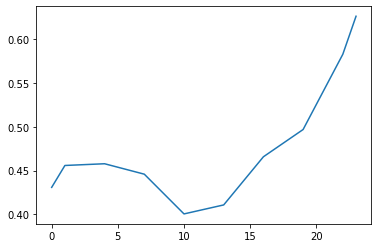

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 31 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 20 input signals.

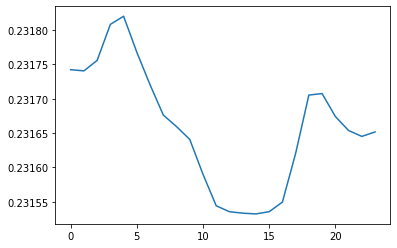

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence, this is done due to the lack of data.

In [ ]:
'''validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))'''

'validation_data = (np.expand_dims(x_test_scaled, axis=0),\n                   np.expand_dims(y_test_scaled, axis=0))'

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (LSTM). We will use the Keras API for this because of its simplicity.

In [ ]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 64 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [ ]:
'''model.add(LSTM(units=64,
              return_sequences=True,
              input_shape=(None, num_x_signals)))'''

'model.add(LSTM(units=64,\n              return_sequences=True,\n              input_shape=(None, num_x_signals)))'

The GRU outputs a batch of sequences of 64 values. We want to predict 1 output-signals, so we add a fully-connected (or dense) layer which maps 64 values down to only 1 values.

The output-signal in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [ ]:
model.add(LSTM(units=64,
              return_sequences=True,
              input_shape=(None, num_x_signals)))
model.add(Dense(16, activation='relu'))

#model.add(Dense(16, activation='relu' ''',kernel_regularizer=tf.keras.regularizers.L2(0.0001)'''))
#model.add(Bidirectional(LSTM(16, activation='sigmoid', return_sequences=True))) 

model.add(Dense(num_y_signals, activation='linear'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training. You may need to experiment with this to get it working.
Since the netowrk is quite simple and shallow.

In [ ]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 5 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [ ]:
warmup_steps = 5

In [ ]:
def custom_mse(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but increasing a lot when prediction is negative.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    #y_true_slice = y_true[:, warmup_steps:, :]
    #y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [ ]:
optimizer = Adam(lr=1e-2)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


We then compile the Keras model so it is ready for training.

In [ ]:
#model.compile(loss=loss_mse_warmup, optimizer=optimizer)
#model.compile(loss=tf.keras.losses.MeanAbsoluteError())
model.compile(loss=tf.keras.losses.MeanSquaredError())


This is a very small model with only two layers. The output shape of `(None, None, 1)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 1 signals. This corresponds to the target signal we want to predict.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          24320     
_________________________________________________________________
dense (Dense)                (None, None, 16)          1040      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 25,377
Trainable params: 25,377
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = 'Training_checkpoints/lstm_checkpoint_finaltuning_splittrivial.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5 , verbose=1)

This is the callback for writing the TensorBoard log during training.

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./base_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.01,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.


Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [ ]:
%%time
model.fit(x=train_dataset,
          epochs=50,
          steps_per_epoch=30,
          validation_data=valid_dataset,
          validation_steps = 10, 
          callbacks=callbacks)

Epoch 1/50
30/30 [==============================] - 105s 3s/step - loss: 0.0062 - val_loss: 0.0064

Epoch 00001: val_loss improved from inf to 0.00642, saving model to Training_checkpoints/lstm_checkpoint_finaltuning_splittrivial.keras
Epoch 2/50
30/30 [==============================] - 102s 3s/step - loss: 0.0016 - val_loss: 0.0064

Epoch 00002: val_loss improved from 0.00642 to 0.00639, saving model to Training_checkpoints/lstm_checkpoint_finaltuning_splittrivial.keras

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 3/50
30/30 [==============================] - 102s 3s/step - loss: 7.2502e-04 - val_loss: 0.0027

Epoch 00003: val_loss improved from 0.00639 to 0.00266, saving model to Training_checkpoints/lstm_checkpoint_finaltuning_splittrivial.keras
Epoch 4/50
30/30 [==============================] - 102s 3s/step - loss: 4.1166e-04 - val_loss: 0.0024

Epoch 00004: val_loss improved from 0.00266 to 0.00237, saving model to Training_checkpoints/lstm_checkpoint_f

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
'''result = model.evaluate(x=np.expand_dims(test_indexed, axis=0),
                        y=np.expand_dims(test_y_indexed, axis=0))'''


1/1 [==============================] - 3s 3s/step - loss: 0.0013


'result = model.evaluate(x=np.expand_dims(test_indexed, axis=0),\n                        y=np.expand_dims(test_y_indexed, axis=0))'

In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.001259574550203979


In [ ]:
#result = 0.00022854468261357397
inverse = y_scaler[0].inverse_transform(np.array(result).reshape(-1,1))
error_perc =abs(np.divide(( inverse) , np.max(y_test)))
print("Relative percentage error on test set is : ", error_perc)

Relative percentage error on test set is :  [[0.77806098]]


In [ ]:
np.array(result).reshape(-1,1)

array([[0.00125957]])

In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [ ]:
def plot_comparison_fulltest():
    """
    Plot the predicted and true output-signals of test set
    """
    # Use test-data.
    x = x_test_scaled[24000:26000]
    y_true = y_test[24000:26000]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    #n = x.shape[1]/sequence_length
    #splits = np.array_split(x, n, axis=1)
    # Use the model to predict the output-signals.
    y_pred = model(x, training = False)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler[0].inverse_transform(y_pred.numpy().squeeze().reshape(-1,1))
    #y_true_rescaled = y_scaler.inverse_transform(y_true)
    #y_pred_rescaled=np.asarray(y_pred).squeeze()
    signal = 'EMISSIONS'
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true[:]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred', alpha=0.8)
    plt.plot([np.mean(signal_true)]* (len(signal_pred)), label='mean')
    # Plot grey box for warmup-period.
    #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(signal)
    plt.legend()
    plt.show()

We can now plot an example of predicted output-signal. It is important to understand what these plots show, as they are actually a bit more complicated than you might think.

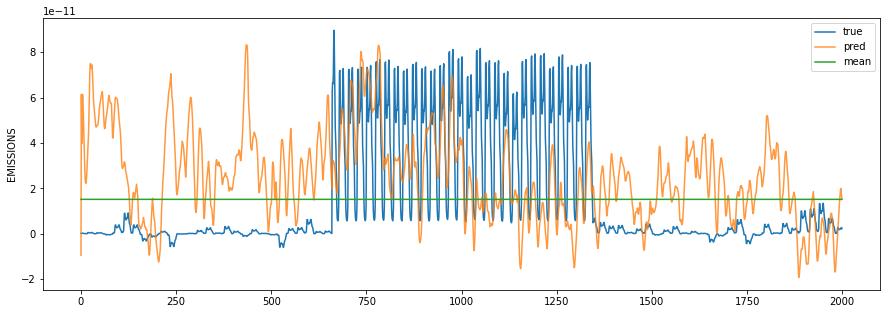

In [ ]:
plot_comparison_fulltest()

## Improvements

The model at least seems to perform a little better than the base model with just location, the overall performance is not sufficient yet since we train the model in the wrong way. 
Here there are the next improvements: 
- Train the model modifying the way the generator gives the data. Right now it select randomly a subsequence from the overall training set, so it is very likely that a single subsequence may contain the end of the final day for a location and the first day of the next location. So a way to improve is to force the generator to select a random subsequene from a single random location. Can be done quite easily by choosing randomly a single location (from the cartesian product of latitudes and longitudes) and than choose randomly a subsequence inside this selection.
- Right now the test set contains latitudes and longitudes never seen in the training set, shuffling smartly the dataset may solve this but pay attention to the previous point 
- Tune Hyperparameters through CROSS-VALIDATION !!
- Not use the Test set as Validation set !!

## Grid search optimization

In [ ]:
'''dataset = CustomGenerator('training',batch_size,sequence_length)

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([sequence_length, num_x_signals], [sequence_length, num_y_signals]))
batch_size = 24
#train_dataset = train_dataset.batch(batch_size)
#train_dataset = train_dataset.repeat()'''

"dataset = CustomGenerator('training',batch_size,sequence_length)\n\ntrain_dataset = tf.data.Dataset.from_generator(lambda: dataset,\n                                               output_types=(tf.float32, tf.float32),\n                                               output_shapes=([sequence_length, num_x_signals], [sequence_length, num_y_signals]))\nbatch_size = 24\n#train_dataset = train_dataset.batch(batch_size)\n#train_dataset = train_dataset.repeat()"

In [ ]:
'''# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
# Function to create model, required for KerasRegressor
def create_model():
  # create model
  model = Sequential()
  model.add(LSTM(units=32, return_sequences=True, input_shape=(None, num_x_signals,)))
  model.add(Dense(16, activation='relu'))
  #model.add(Bidirectional(LSTM(16, activation='sigmoid', return_sequences=True))) 
  model.add(Dense(num_y_signals, activation='linear'))
  # Compile model
  optimizer = Adam(lr=1e-3)
  model.compile(loss=tf.keras.losses.MeanSquaredError())  
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 30, 50]
n_neurons_recurrent = [32, 48]
n_neurons_dense = [8, 16, 32]
x = train_dataset.as_numpy_iterator()
#y = generator(10000)

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X = x, y = y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'# Use scikit-learn to grid search the batch size and epochs\nimport numpy\nfrom sklearn.model_selection import GridSearchCV\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.wrappers.scikit_learn import KerasRegressor\n# Function to create model, required for KerasRegressor\ndef create_model():\n  # create model\n  model = Sequential()\n  model.add(LSTM(units=32, return_sequences=True, input_shape=(None, num_x_signals,)))\n  model.add(Dense(16, activation=\'relu\'))\n  #model.add(Bidirectional(LSTM(16, activation=\'sigmoid\', return_sequences=True))) \n  model.add(Dense(num_y_signals, activation=\'linear\'))\n  # Compile model\n  optimizer = Adam(lr=1e-3)\n  model.compile(loss=tf.keras.losses.MeanSquaredError())  \n  return model\n# fix random seed for reproducibility\nseed = 7\nnumpy.random.seed(seed)\n\n# create model\nmodel = KerasRegressor(build_fn=create_model, verbose=0)\n# define the grid search parameters\nbatch_size = [10, 20, 40, 60, 80, 100]\n